In [0]:
system("add-apt-repository -y ppa:marutter/rrutter")
system("add-apt-repository -y ppa:marutter/c2d4u")
system("apt-get update")
system("apt install -y r-cran-rstan")

In [0]:
system("wget http://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip")

In [0]:
zip <- "/content/UCI HAR Dataset.zip"
out <- "/content"
unzip(zip, exdir=out)

In [0]:
install.packages("randomForest")
install.packages("ggplot2")
install.packages("caret")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
also installing the dependencies ‘numDeriv’, ‘SQUAREM’, ‘lava’, ‘prodlim’, ‘iterators’, ‘data.table’, ‘gower’, ‘ipred’, ‘RcppRoll’, ‘timeDate’, ‘foreach’, ‘ModelMetrics’, ‘recipes’



In [0]:
library(randomForest)
library(ggplot2)
library(caret)

Loading required package: lattice


In [0]:
options(repr.plot.width  = 5,
        repr.plot.height = 4)
Sys.setenv(USE_CXX14 = 1)

In [0]:
set.seed(123)

In [0]:
train_x <- read.table("/content/UCI HAR Dataset/train/X_train.txt")
train_y <-read.table("/content/UCI HAR Dataset/train/y_train.txt")

test_x <- read.table("/content/UCI HAR Dataset/test/X_test.txt")
test_y <- read.table("/content/UCI HAR Dataset/test/y_test.txt")

In [0]:
cols <- readLines("/content/UCI HAR Dataset/features.txt")

In [0]:
colnames(train_x) <- make.names(cols)
colnames(test_x) <- make.names(cols)

colnames(train_y) <- "label"
colnames(test_y) <- "label"

In [0]:
train <- cbind(train_x, train_y)
test <- cbind(test_x , test_y)

all_data <- rbind(train, test)

In [0]:
all_data$label <- factor(all_data$label)

In [0]:
dim(train)
dim(test) 
dim(all_data)

[1] 7352  562

[1] 2947  562

[1] 10299   562

In [0]:
subset <- sample(1:7352)


In [0]:
rfmodel <- randomForest(label~., data=all_data[subset,])

In [0]:
rfmodel


Call:
 randomForest(formula = label ~ ., data = all_data[subset, ]) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 23

        OOB estimate of  error rate: 1.69%
Confusion matrix:
     1    2   3    4    5    6 class.error
1 1209    6  11    0    0    0 0.013866232
2    1 1067   5    0    0    0 0.005591799
3    5    8 973    0    0    0 0.013184584
4    0    1   0 1236   49    0 0.038880249
5    0    0   0   38 1336    0 0.027656477
6    0    0   0    0    0 1407 0.000000000

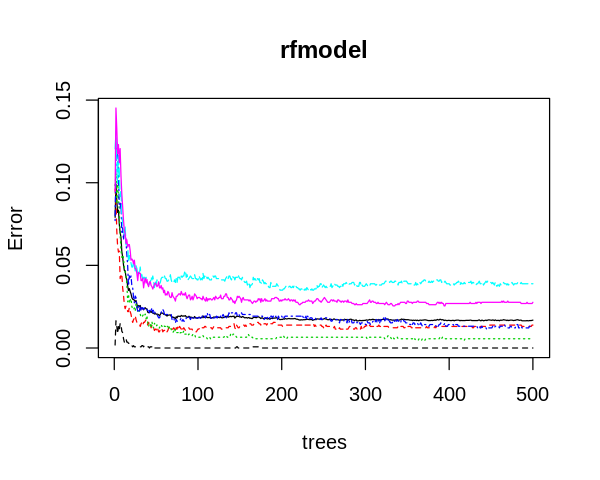

In [0]:
plot(rfmodel)

This depicts that the error decreases as number of trees is increased.




In [0]:
pred<-predict(rfmodel,all_data[-subset,])


In [0]:
caret::confusionMatrix(pred, all_data[-subset , 562])

Confusion Matrix and Statistics

          Reference
Prediction   1   2   3   4   5   6
         1 481  34  21   0   0   0
         2   5 430  44   0   0   0
         3  10   7 355   0   0   0
         4   0   0   0 440  38   0
         5   0   0   0  51 494   0
         6   0   0   0   0   0 537

Overall Statistics
                                          
               Accuracy : 0.9287          
                 95% CI : (0.9189, 0.9378)
    No Information Rate : 0.1822          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.9143          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4 Class: 5 Class: 6
Sensitivity            0.9698   0.9130   0.8452   0.8961   0.9286   1.0000
Specificity            0.9776   0.9802   0.9933   0.9845   0.9789   1.0000
Pos Pred Value         0.8974   0.8977   0.9543

In [0]:
subset <- sample(1:7352, 5000)

In [0]:
oob.err=double(11)
test.err=double(11)

# mtry is no of Variables randomly chosen at each split
for(mtry in 20:30) 
{
  rf = randomForest(label~. , data = all_data[subset,] ,mtry=mtry,ntree=400, xtest=train[-subset,-562],
                                                   ytest=factor(train[-subset , 562])) 
  oob.err[mtry] = rf$err.rate[nrow(rf$err.rate), "OOB"] #Error of all Trees fitted
  test.err[mtry]= rf$test$err.rate[nrow(rf$test$err.rate), "Test"] 
}

In [0]:
library(ggplot2)


In [0]:
convert_to_dataframe <- function(err_vec)
{
   data <- as.data.frame(err_vec[20:30])
   colnames(data) <- "error"
   seqn <- as.data.frame(20:30)
   colnames(seqn) <- "mtry"
   dataframe <- cbind(data, seqn)
   return (dataframe)
   
 }


In [0]:
oob_data <- convert_to_dataframe(oob.err)
test_data <- convert_to_dataframe(test.err)

In [0]:
oob_data$type <- "OOB"
test_data$type <- "Test"

In [0]:
data <- rbind(oob_data, test_data)

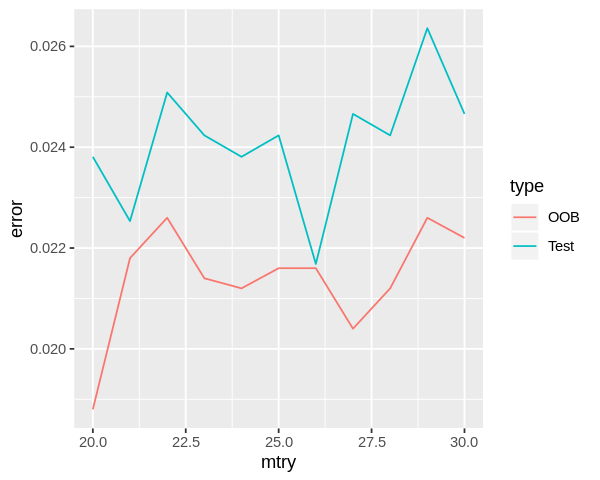

In [0]:
ggplot(data, aes(mtry, error)) + geom_line(aes(color=type))

From above 2 graphs, mtry = 26 seems to a suitable value to me and instead of ntree=400, I shall take ntree = 500

In [0]:
require(dplyr)

Loading required package: dplyr

Attaching package: ‘dplyr’

The following object is masked from ‘package:randomForest’:

    combine

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



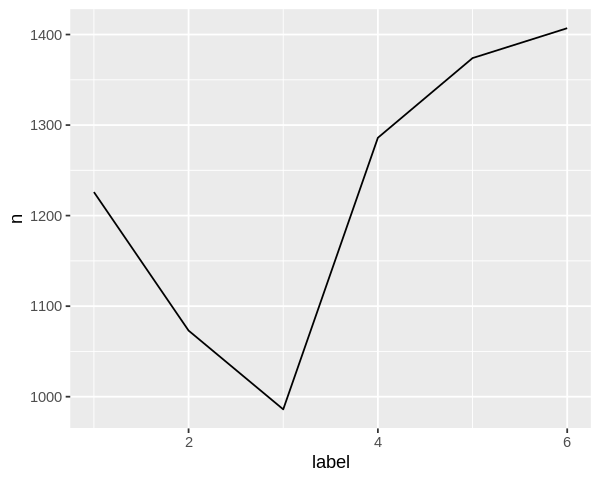

In [0]:
ggplot(data = train_y %>% group_by(label) %>% summarize(n=n()), aes(label, n)) + geom_line()

This summary does not advocate the presence of largely significant class-imbalance. So, for the time being , I will not be bothered about presence of class-imbalance.

In [0]:
dst <- dist(train_x)

In [0]:
dend_com <- hclust(dst, method="complete")
dend_avg <- hclust(dst, method="average")
dend_sing <- hclust(dst, method="single")
dend_war <- hclust(dst, method="ward.D")

In [0]:
c_com=cophenetic(dend_com)
c_avg=cophenetic(dend_avg)
c_sing=cophenetic(dend_sing)
c_war=cophenetic(dend_war)


In [0]:
print("Complete")
print(cor(dst, c_com))
print("Average")
print(cor(dst, c_avg))
print("Single")
print(cor(dst, c_sing))
print("War")
print(cor(dst, c_war))

[1] "Complete"
[1] 0.7082044
[1] "Average"
[1] 0.8829588
[1] "Single"
[1] 0.7620606
[1] "War"
[1] 0.8444204


The Correlation for the Average method is highest and Ward is not far behind. I am choosing Ward method.

In [0]:
clusters <- cutree(dend_war, k=6)

In [0]:
d <- as.data.frame(clusters)
colnames(d) <- "clusters_hc"

d %>% group_by(clusters_hc) %>% summarize(n = n())

clusters_hc,n
<int>,<int>
1,1557
2,1232
3,1278
4,1666
5,468
6,1151


In [0]:
a <- kmeans(train_x, centers=6)

In [0]:
d2 <- as.data.frame(a$cluster)
colnames(d2) <- "clusters_k"

d2 %>% group_by(clusters_k) %>% summarize(n = n())

clusters_k,n
<int>,<int>
1,805
2,1265
3,999
4,1604
5,648
6,2031


Let's see if the clustered values lead us to some improvement over the previous results or not.

In [0]:
d <- scale(d)
d2 <- scale(d2)

In [0]:
dst_test <- dist(test_x)

In [0]:
dendtest_war <- hclust(dst_test, method="ward.D")
cluster_test <- cutree(dendtest_war, k=6)

In [0]:
d_test <- as.data.frame(cluster_test)
colnames(d_test) <- "clusters_hc"
d_test <- scale(d_test)

In [0]:
a_test <- kmeans(test_x, centers=6)

In [0]:
d2_test <- as.data.frame(a_test$cluster)
colnames(d2_test) <- "clusters_k"
d2_test <- scale(d2_test)

In [0]:
train_x <- cbind(train_x, d, d2)
test_x <- cbind(test_x, d_test, d2_test)

In [0]:
train_f <- cbind(train_x, train_y)
test_f <- cbind(test_x , test_y)

In [0]:
train_f$label <- factor(train_f$label)
test_f$label <- factor(test_f$label)

In [0]:
model <- randomForest(label~. , data = train_f, mtry = 26, ntree=500)

In [0]:
model


Call:
 randomForest(formula = label ~ ., data = train_f, mtry = 26,      ntree = 500) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 26

        OOB estimate of  error rate: 1.74%
Confusion matrix:
     1    2   3    4    5    6 class.error
1 1210    6  10    0    0    0 0.013050571
2    0 1067   6    0    0    0 0.005591799
3    4    9 973    0    0    0 0.013184584
4    0    1   0 1233   52    0 0.041213064
5    0    0   0   40 1334    0 0.029112082
6    0    0   0    0    0 1407 0.000000000

In [0]:
prediction <- predict(model, test_f)

In [0]:
install.packages("e1071")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


In [0]:
require(e1071)

Loading required package: e1071


In [0]:
caret::confusionMatrix(prediction , test_f[, 564])

Confusion Matrix and Statistics

          Reference
Prediction   1   2   3   4   5   6
         1 480  33  17   0   0   0
         2   6 432  46   0   0   0
         3  10   6 357   0   0   0
         4   0   0   0 438  52   0
         5   0   0   0  53 480   0
         6   0   0   0   0   0 537

Overall Statistics
                                          
               Accuracy : 0.9243          
                 95% CI : (0.9142, 0.9336)
    No Information Rate : 0.1822          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.909           
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4 Class: 5 Class: 6
Sensitivity            0.9677   0.9172   0.8500   0.8921   0.9023   1.0000
Specificity            0.9796   0.9790   0.9937   0.9788   0.9781   1.0000
Pos Pred Value         0.9057   0.8926   0.9571

Accuracy has improved a bit

In [0]:
all_d <- rbind(train_x , test_x)

In [0]:
mod_pca <- prcomp(all_d, center=F, scale=F)

In [0]:
mod <- mod_pca$sdev^2

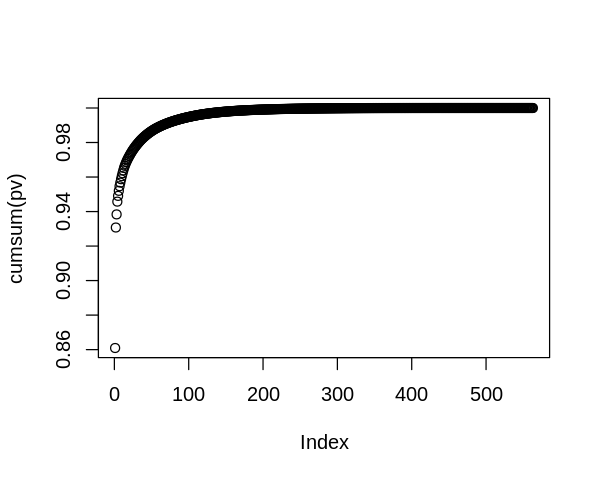

In [0]:
pv <- mod / sum(mod)
plot(cumsum(pv))

In [0]:
summary(mod_pca)

Importance of components:
                           PC1     PC2    PC3    PC4     PC5     PC6     PC7
Standard deviation     16.1876 4.60965 1.5213 1.5009 1.00635 0.94452 0.90169
Proportion of Variance  0.8609 0.06981 0.0076 0.0074 0.00333 0.00293 0.00267
Cumulative Proportion   0.8609 0.93075 0.9384 0.9457 0.94908 0.95201 0.95468
                           PC8     PC9    PC10    PC11    PC12    PC13    PC14
Standard deviation     0.79562 0.77249 0.73863 0.71723 0.70272 0.66444 0.60866
Proportion of Variance 0.00208 0.00196 0.00179 0.00169 0.00162 0.00145 0.00122
Cumulative Proportion  0.95676 0.95872 0.96051 0.96220 0.96383 0.96528 0.96649
                          PC15    PC16    PC17   PC18    PC19   PC20    PC21
Standard deviation     0.58438 0.56658 0.52897 0.5232 0.50100 0.4927 0.48529
Proportion of Variance 0.00112 0.00105 0.00092 0.0009 0.00082 0.0008 0.00077
Cumulative Proportion  0.96762 0.96867 0.96959 0.9705 0.97131 0.9721 0.97289
                          PC22    PC23    

In [0]:
train_pca <- mod_pca$x[1:7352,1:23]
test_pca <- mod_pca$x[-(1:7352), 1:23]

In [0]:
train_pca_f <- cbind(train_pca , train_y)
test_pca_f   <- cbind(test_pca, test_y)
train_pca_f$label <- factor(train_pca_f$label)
test_pca_f$label  <- factor(test_pca_f$label)

In [0]:
model_pca_rf <- randomForest(label~. , data = train_pca_f, ntree=500)

In [0]:
model_pca_rf


Call:
 randomForest(formula = label ~ ., data = train_pca_f, ntree = 500) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 4

        OOB estimate of  error rate: 6.41%
Confusion matrix:
     1    2   3    4    5    6 class.error
1 1204    7  15    0    0    0 0.017944535
2    9 1046  18    0    0    0 0.025163094
3   11   16 959    0    0    0 0.027383367
4    0    1   0 1030  245   10 0.199066874
5    0    0   0  136 1238    0 0.098981077
6    0    0   0    3    0 1404 0.002132196

In [0]:
pred_pca_rf <- predict(model_pca_rf , test_pca_f)

In [0]:
caret::confusionMatrix(pred_pca_rf , test_pca_f[,24])

Confusion Matrix and Statistics

          Reference
Prediction   1   2   3   4   5   6
         1 476  17  52   0   0   0
         2   6 430  48   0   0   0
         3  14  24 320   0   0   0
         4   0   0   0 397  69  15
         5   0   0   0  94 463   0
         6   0   0   0   0   0 522

Overall Statistics
                                          
               Accuracy : 0.885           
                 95% CI : (0.8729, 0.8963)
    No Information Rate : 0.1822          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.8617          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4 Class: 5 Class: 6
Sensitivity            0.9597   0.9130   0.7619   0.8086   0.8703   0.9721
Specificity            0.9718   0.9782   0.9850   0.9658   0.9611   1.0000
Pos Pred Value         0.8734   0.8884   0.8939

In [0]:
require(nnet)

Loading required package: nnet


In [0]:
all_d <- cbind(all_data[, 1:561], class.ind(as.factor(all_data$label)))
colnames(all_d) <- c(colnames(all_data[, 1:561]), "l1", "l2", "l3", "l4", "l5", "l6")

In [0]:
install.packages("neuralnet")
require(neuralnet)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
also installing the dependency ‘Deriv’

Loading required package: neuralnet

Attaching package: ‘neuralnet’

The following object is masked from ‘package:dplyr’:

    compute



In [0]:
n <- names(all_d)
f <- as.formula(paste("l1 + l2 + l3 + l4 + l5 + l6 ~", paste(n[!n %in% c("l1","l2","l3", "l4", "l5", "l6")], collapse = " + ")))

In [0]:
my_fun <- function(x) relu(x)

In [0]:
??relu

In [0]:
nn <- neuralnet(f,
                data = all_d[1:7352,],
                hidden = c(256, 16, 6),
                act.fct = "logistic",
                linear.output = FALSE,
                lifesign = "minimal", err.fct="ce", rep=10)

hidden: 256, 16, 6    thresh: 0.01    rep:  1/10    steps:     151	error: 0.05585	time: 53.53 secs
hidden: 256, 16, 6    thresh: 0.01    rep:  2/10    steps:     156	error: 0.05295	time: 52.23 secs
hidden: 256, 16, 6    thresh: 0.01    rep:  3/10    steps:     141	error: 0.06081	time: 46.45 secs
hidden: 256, 16, 6    thresh: 0.01    rep:  4/10    steps:     152	error: 0.04074	time: 49.79 secs
hidden: 256, 16, 6    thresh: 0.01    rep:  5/10    steps:     140	error: 0.09452	time: 45.57 secs
hidden: 256, 16, 6    thresh: 0.01    rep:  6/10    steps:     176	error: 0.04566	time: 57.11 secs
hidden: 256, 16, 6    thresh: 0.01    rep:  7/10    steps:     147	error: 0.08397	time: 48.25 secs
hidden: 256, 16, 6    thresh: 0.01    rep:  8/10    steps:     148	error: 0.08272	time: 48.31 secs
hidden: 256, 16, 6    thresh: 0.01    rep:  9/10    steps:     168	error: 0.04903	time: 54.14 secs
hidden: 256, 16, 6    thresh: 0.01    rep: 10/10    steps:     157	error: 0.06357	time: 51.01 secs


In [0]:
pr.nn <- compute(nn, all_data[-(1:7352), -562])
pr.nn_ <- pr.nn$net.result

In [0]:
orig <- max.col(all_d[-(1:7352), (562:567)])
pr.nn_2 <- max.col(pr.nn_)
mean(pr.nn_2 == orig)

[1] 0.9287411

Seems like randomForest does better with less effort.

Time for Keras Model

In [0]:
install.packages("keras")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


In [0]:
library(keras)
#library(tensorflow)

In [0]:
#system("sudo apt-get install python-virtualenv")

In [0]:
#install_tensorflow()

Creating virtualenv for TensorFlow at  ~/.virtualenvs/r-tensorflow 
Installing TensorFlow ...

Installation complete.



In [0]:
head(train_x)

X1.tBodyAcc.mean...X,X2.tBodyAcc.mean...Y,X3.tBodyAcc.mean...Z,X4.tBodyAcc.std...X,X5.tBodyAcc.std...Y,X6.tBodyAcc.std...Z,X7.tBodyAcc.mad...X,X8.tBodyAcc.mad...Y,X9.tBodyAcc.mad...Z,X10.tBodyAcc.max...X,⋯,X552.fBodyBodyGyroJerkMag.meanFreq..,X553.fBodyBodyGyroJerkMag.skewness..,X554.fBodyBodyGyroJerkMag.kurtosis..,X555.angle.tBodyAccMean.gravity.,X556.angle.tBodyAccJerkMean..gravityMean.,X557.angle.tBodyGyroMean.gravityMean.,X558.angle.tBodyGyroJerkMean.gravityMean.,X559.angle.X.gravityMean.,X560.angle.Y.gravityMean.,X561.angle.Z.gravityMean.
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.2885845,-0.02029417,-0.1329051,-0.9952786,-0.9831106,-0.9135264,-0.9951121,-0.9831846,-0.9235270,-0.9347238,⋯,-0.07432303,-0.2986764,-0.7103041,-0.11275434,0.030400372,-0.4647614,-0.01844588,-0.8412468,0.1799406,-0.05862692
0.2784188,-0.01641057,-0.1235202,-0.9982453,-0.9753002,-0.9603220,-0.9988072,-0.9749144,-0.9576862,-0.9430675,⋯,0.15807454,-0.5950509,-0.8614993,0.05347695,-0.007434566,-0.7326262,0.70351059,-0.8447876,0.1802889,-0.05431672
0.2796531,-0.01946716,-0.1134617,-0.9953796,-0.9671870,-0.9789440,-0.9965199,-0.9636684,-0.9774686,-0.9386916,⋯,0.41450281,-0.3907482,-0.7601037,-0.11855926,0.177899480,0.1006992,0.80852908,-0.8489335,0.1806373,-0.04911782
0.2791739,-0.02620065,-0.1232826,-0.9960915,-0.9834027,-0.9906751,-0.9970995,-0.9827498,-0.9893025,-0.9386916,⋯,0.40457253,-0.1172902,-0.4828445,-0.03678797,-0.012892494,0.6400110,-0.48536645,-0.8486494,0.1819348,-0.04766318
0.2766288,-0.01656965,-0.1153619,-0.9981386,-0.9808173,-0.9904816,-0.9983211,-0.9796719,-0.9904411,-0.9424691,⋯,0.08775301,-0.3514709,-0.6992052,0.12332005,0.122541960,0.6935783,-0.61597061,-0.8478653,0.1851512,-0.04389225
0.2771988,-0.01009785,-0.1051373,-0.9973350,-0.9904868,-0.9954200,-0.9976274,-0.9902177,-0.9955489,-0.9424691,⋯,0.01995331,-0.5454101,-0.8446193,0.08263215,-0.143439010,0.2750408,-0.36822404,-0.8496316,0.1848225,-0.04212638


In [0]:
require(dplyr)

train_y %>% group_by(label) %>% summarize(n=n())

label,n
<int>,<int>
1,1226
2,1073
3,986
4,1286
5,1374
6,1407


In [0]:
train_y <- to_categorical(train_y - 1, num_classes=6)

In [0]:
model = keras_model_sequential() %>%   
  layer_dense(units = 128, activation = "relu", input_shape = ncol(train_x)) %>%
  layer_dense(units = 64, activation = "relu") %>%
  layer_dropout(0.4) %>%
  layer_dense(units = ncol(train_y), activation = "softmax")

In [0]:
summary(model)

________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
dense_12 (Dense)                    (None, 128)                     71936       
________________________________________________________________________________
dense_13 (Dense)                    (None, 64)                      8256        
________________________________________________________________________________
dropout_1 (Dropout)                 (None, 64)                      0           
________________________________________________________________________________
dense_14 (Dense)                    (None, 6)                       390         
Total params: 80,582
Trainable params: 80,582
Non-trainable params: 0
________________________________________________________________________________


In [0]:
compile(model, loss = "categorical_crossentropy", optimizer = "adagrad", metrics = "accuracy")

In [0]:
history <- fit(model,  as.matrix(train_x), train_y, epochs = 40, batch_size = 128, validation_split = 0.2)

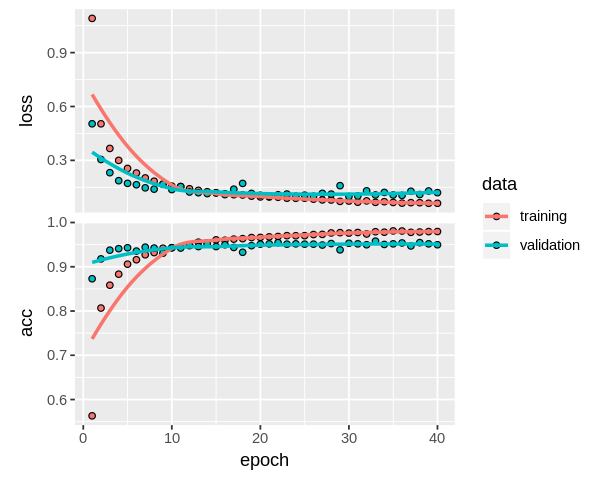

In [0]:
plot(history)

In [0]:
test_y <- to_categorical(test_y -1 , num_classes=6)

In [0]:
evaluate(model, as.matrix(test_x), test_y, verbose=0)

$loss
[1] 0.1652824

$acc
[1] 0.9389209

In [0]:
model2 = keras_model_sequential() %>%   
  layer_dense(units = 256, activation = "relu", input_shape = ncol(train_x)) %>%
  layer_dropout(0.5) %>%
  layer_dense(units = 16, activation = "relu") %>%
  layer_dropout(0.5) %>%
  layer_dense(units = ncol(train_y), activation = "softmax")

In [0]:
compile(model2, loss = "categorical_crossentropy", optimizer = "adagrad", metrics = "accuracy")

In [0]:
hist <- fit(model2,  as.matrix(train_x), train_y, epochs = 50, batch_size = 128, validation_split = 0.2)

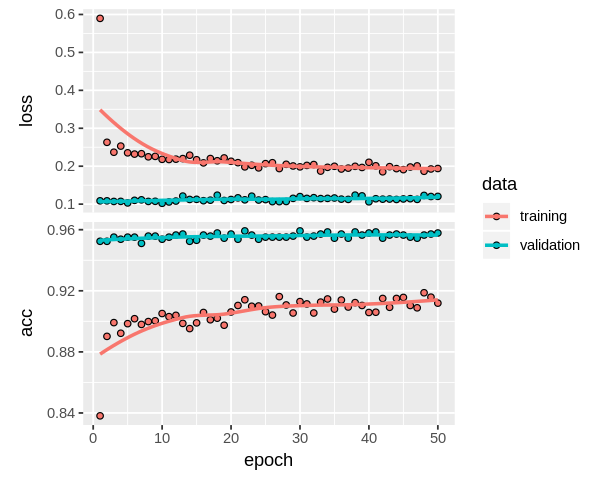

In [0]:
plot(hist)

In [0]:
evaluate(model2, as.matrix(test_x), test_y, verbose=0)

$loss
[1] 0.2145607

$acc
[1] 0.9450288

In [0]:
y <-read.table("/content/UCI HAR Dataset/train/y_train.txt")
colnames(y) <- "label"
class(y %>% group_by(label) %>% summarize(n=n()))

[1] "tbl_df"     "tbl"        "data.frame"

In [0]:
list(y %>% group_by(label) %>% summarize(n=n()))

label,n
<int>,<int>
1,1226
2,1073
3,986
4,1286
5,1374
6,1407


In [0]:
cn  <- c(1226, 1073, 986, 1286, 1374, 1407)
cn  <- 7352/cn
cn <- cn/7
nm <- c(0,1,2,3,4,5)
cn <- setNames(as.list(cn), nm)
#cn <- cn/7

In [0]:
cn

$`0`
[1] 0.8566768

$`1`
[1] 0.978831

$`2`
[1] 1.065198

$`3`
[1] 0.8167074

$`4`
[1] 0.7644001

$`5`
[1] 0.7464717

In [0]:
model3 = keras_model_sequential() %>%   
  layer_dense(units = 128, activation = "relu", input_shape = ncol(train_x)) %>%
  layer_dropout(0.4) %>%
  layer_dense(units = 16, activation = "relu") %>%
  layer_dropout(0.3) %>%
  layer_dense(units = ncol(train_y), activation = "softmax")

In [0]:
compile(model3, loss = "categorical_crossentropy", optimizer = "adagrad", metrics = "accuracy")

In [0]:
his <- fit(model3,  as.matrix(train_x), train_y, class_weight= cn, epochs = 50, batch_size = 128, validation_split = 0.2)

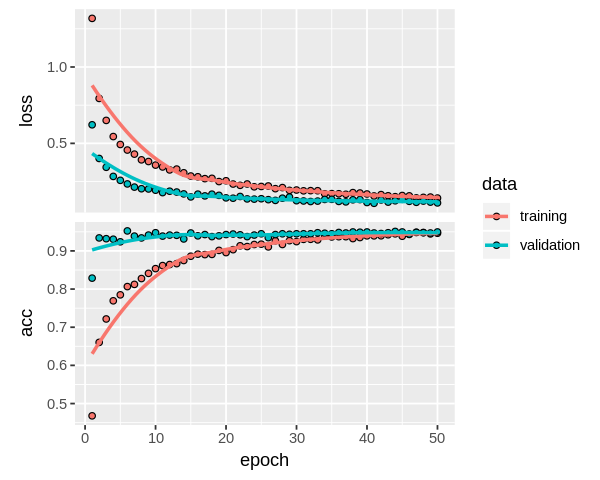

In [0]:
plot(his)

In [0]:
evaluate(model3, as.matrix(test_x), test_y, verbose=0)

$loss
[1] 0.1799698

$acc
[1] 0.9331524

The 2nd model (Keras) gives an accuracy of ~95% on the test set. So, it 
performs the best among all models. But loss incurred by the 1st neural network model (built using Keras) is the least. So , even that is not far behind.